# Assignment 3

In [1]:
import numpy as np
from scipy import optimize
import intersection 
import matplotlib.pyplot as plt

def phi(theta, M):
    out = optimize.fsolve(lambda x: fun(x,M,theta),0.01)
    out = np.append(out, optimize.fsolve(lambda x: fun(x,M,theta),np.pi/2))
    return out
def theta(x,M):
    out = 2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    out = np.arctan(out)
    return out
def fun(x,M,theta):
    f=np.tan(theta)-2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    return f
def fun2(x,M):
    theta=np.arctan(2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2))
    return theta
def thetaMax(M):
    phi=optimize.fmin(lambda x: -fun2(x,M),0.1)
    theta=fun2(phi,M)
    return theta

class state(object):
  def __init__(self,p=100000,M=1.5,T=300,R=287,phi=0,gamma=1.4):
    self.p=p
    self.M=M
    self.T=T
    self.gamma=gamma
    self.phi=phi
    self.R=R
    self.rho=self.p/(self.R*self.T)
    self.u=self.M*np.sqrt(self.gamma*self.R*self.T)
    
def oblique(state0,theta1=10*np.pi/180,weak='True'):
  #theta=theta
  p=phi(theta1,state0.M)
  tmax=thetaMax(state0.M)
  print("Theta max :",tmax*180/np.pi)
  if tmax<theta1:
        print("Shock detached")
  else:
    if weak=='True':
      ph=p[0]
    else:
      ph=p[1]
    M1=np.sqrt((1+(state0.gamma-1)*0.5*(state0.M*np.sin(ph))**2)/(state0.gamma*(state0.M*np.sin(ph))**2-(state0.gamma-1)*0.5))/(np.sin(ph-theta1))
    p2=state0.p*(1+2*state0.gamma*((state0.M*np.sin(ph))**2-1)/(1+state0.gamma))
    T2=state0.T*(p2/state0.p)*(2+(state0.gamma-1)*(state0.M*np.sin(ph))**2)/((1+state0.gamma)*(state0.M*np.sin(ph))**2)
    state1=state(M=M1,p=p2,T=T2)
    state1.phi = ph
    state1.theta= theta1
    return state1

def ST(state0,theta1):
  state1=oblique(state0,theta1=theta1)
  if theta1<thetaMax(state1.M):
        print("This case is a Regular reflection")
        print("Solving using 2 shock theory . . .")
        state2=oblique(state1,theta1=theta1)
        return state1,state2
  else:
    print("This case is a Mach reflection")
    print("Solving for the Standard solution using 3 shock theory...")
    phi = ThreeST(state0,state1,theta1)
    phi2 = phi[0]
    phi3 = phi[1]
    theta2 = theta(phi2,state1.M)
    print(theta2*180/np.pi)
    theta3 = theta(phi3,state0.M)
    state3 = oblique(state0,theta1=theta3)
    state3.phi = phi3
    state3.theta = theta3
    state2 = oblique(state1,theta1=theta2)
    state2.phi = phi2
    state2.theta =theta2
    return state1,state2,state3

def ThreeST(state0,state1,theta):
    p = np.array([[]])
    p = np.append(p,state0.M)  # M0
    p = np.append(p,state1.M)  # M1
    p = np.append(p,theta)  # theta
    p = np.append(p,state1.p/state0.p) # p1/p0
    return optimize.fsolve(lambda x: fun3(x,p),100*np.array([0.01,0.01]))
    
def fun3(x,p,gamma = 1.4):
    """
    x[0] - phi2
    x[1] - phi3
    """
    f=np.array([])
    f=np.append(f,(1+2*(p[1]**2*np.sin(x[0])**2-1)*gamma/(gamma+1))*p[3]-(1+2*(p[0]**2*np.sin(x[1])**2-1)*gamma/(gamma+1)))
    f=np.append(f,p[2]-theta(x[0],p[1])-theta(x[1],p[0]))
    return f
    
    
def polar(M0,both = 'True',type ='p', positive='True',gamma=1.4):
    tmax = thetaMax(M0)
    print("ThetaMax:", tmax*180/np.pi)
    theta = np.linspace(0,tmax,100)
    if type == 'p':
      pWeak = np.asarray([pRatio(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False') for k in theta])
    elif type == 'M':
      pWeak = np.asarray([Mj(k,M0) for k in theta])
      pStrong = np.asarray([Mj(k,M0,weak = 'False') for k in theta])
    elif type == 'rho':
      pWeak = np.asarray([rho(k,M0) for k in theta])
      pStrong = np.asarray([rho(k,M0,weak = 'False') for k in theta])
    elif type == 'T':
      pWeak = np.asarray([pRatio(k,M0)/rho(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False')/rho(k,M0,weak = 'False') for k in theta])  
    theta = np.append(theta,np.flipud(theta))
    p = np.append(pWeak,np.flipud(pStrong))
    if both =='True':
       p = np.append(p,np.flipud(p))
       theta = np.append(theta,np.flipud(-theta))
    return theta, p


def plot(theta,p,label,name='output'):
    for k,j,m in zip(theta,p,label):
        plt.plot(theta[k]*180/np.pi,p[j],label=label[m])
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('theta')
    plt.savefig("%s.eps"%name, format='eps', dpi=1000)
    plt.show()
  
   
def Mj(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

def rho(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    rho=((1+gamma)*(M*np.sin(z))**2)/(2+(gamma-1)*(M*np.sin(z))**2)
    return rho    
    
def pRatio(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p

def pRatioMax(M):
    return optimize.fmin(lambda x: -pRatio(x,M,gamma=1.4),0.1)

def nu(M,gamma=1.4):
    return np.sqrt((gamma+1)/(gamma-1))*np.arctan(np.sqrt((gamma-1)*(M**2-1)/(gamma+1)))-np.arctan(np.sqrt(M**2-1))

"""
def Mprandtl(nu0,gamma=1.4):
    return optimize.fmin(lambda x: nu0-nu(x),0.01)
"""

def M(nu):
    """
    obtained using Hall's approximation
    """
    nu0 = np.pi*0.5*(np.sqrt(6)-1)
    A = 1.3604
    B = 0.0962
    C = -0.5127
    D = -0.6722
    E = -0.3278
    y = (nu/nu0)**(2/3)
    return (1+A*y+B*y**2+C*y**3)/(1+D*y+E*y**2)

def pRatioIsen(M1,M2,gamma=1.4):
    return ((1+(gamma-1)*0.5*M1**2)/(1+(gamma-1)*0.5*M2**2))**(gamma/(gamma-1))

def polarIsen(M1, thetamax = 0,  gamma=1.4):
    nu1 = nu(M1)
    nu2max =  np.pi*0.5*(np.sqrt((gamma+1)/(gamma-1))-1)
    if thetamax == 0 :
        thetamax = nu2max-nu1
    theta = np.linspace(0,thetamax,100)    
    M2 = M(theta+nu1)
    p = pRatioIsen(M1, M2,gamma=gamma)
    theta = np.append(theta,np.flipud(theta))
    theta = np.append(theta,np.flipud(-theta))
    p = np.append(p,np.flipud(p))
    p = np.append(p,np.flipud(p))
    return theta,p

def Mprandtl(theta,M0):
    nu0=nu(M0)
    M1 = M(theta+nu0)
    return M1
    


In [2]:
# freestream
def diamonAirfoil(M0=3, beta=10,alpha=5):
    
    beta  = beta*np.pi/180    # half angle 
    alpha = alpha*np.pi/180     # AOA
    t1 = -beta+alpha
    t2 = beta+alpha

    if t1<0:
      M1u_=Mj(-t1,M0)
      p1u_ = pRatio(-t1,M0)
      l1 = r'$i_u$ - incident shock upper'
      l2 = r'$t_l$ - trailing edge shock lower'
    elif t1>0:
      M1u_=Mprandtl(t1,M0)
      p1u_=pRatioIsen(M0,M1u_)
      l1 = r'$i_u$ - incident expansion upper'
      l2 = r'$t_l$ - trailing expansion shock lower'
    else:
      M1u_=M0
      p1u_=1
      l1 = r'$i_u$ - straight flow'
      l2=l1

    M1l_=Mj(t2,M0) 
    p1l_=pRatio(t2,M0)
    M2u_=Mprandtl(2*beta,M1u_)
    M2l_=Mprandtl(2*beta,M1l_)
    p2u_=pRatioIsen(M1u_,M2u_)
    p2l_=pRatioIsen(M1l_,M2l_)

    theta1l, p1l = polar(M0)

    if t1<0:
      theta1u, p1u = polar(M0)
    else:
      theta1u,p1u = polarIsen(M0)
    
    theta2u,p2u = polarIsen(M1u_,thetamax=thetaMax(M0))
    theta2l,p2l = polarIsen(M1l_,thetamax=thetaMax(M0))

    theta3u, p3u = polar(M2u_)
    if t1<0:
      theta3l, p3l = polar(M2l_)
    else:
      theta3l, p3l = polarIsen(M2l_,thetamax=thetaMax(M0))
    p1u_= np.interp(abs(t1),theta1u[:100],p1u[:100])
    p1l_=np.interp(t2,theta1l[:100],p1l[:100])

    theta={1:theta1u,
           2:theta1l,
           3:theta2u+abs(t1),
           4:theta2l-t2,
           5:theta3u+abs(t1)-2*beta,
           6:theta3l-t2+2*beta
          }
 
    p    = {1:p1u,
            2:p1l,
            3: p2u*p1u_,
            4: p2l*p1l_,
            5: p3u*p2u_*p1u_,
            6: p3l*p2l_*p1l_
           }
    
    label = {1: l1,
             2: 'i - incident shock lower',
             3: r'$e_u$ - upper expansion',
             4: r'$e_l$ - lower expansion',
             5: r'$t_u$ - trailing edge shock upper',
             6: l2
            }
    y1 =p2u*p1u_
    y3=p3u*p2u_*p1u_
    y2 = p2l*p1l_
    y4=p3l*p2l_*p1l_
    plot(theta,p,label,name='alpha'+'_'+str(alpha*180/np.pi)+'_'+'beta'+'_'+str(beta*180/np.pi))

    x,y=intersection.intersection(theta3u+abs(t1)-2*beta,y1,theta3l-t2+2*beta,y2)
    x,y=intersection.intersection(theta3u+abs(t1),y3,theta3l-t2,y4)
    print("Pressure ration solutions:")
    print(x[0]*180/np.pi, "degrees :", y[0])
    print(x[1]*180/np.pi, "degrees :", y[1])
    x0=x[np.argmin(abs(x))]
    y0=y[np.argmin(abs(x))]
    p3u_=y0/(p2u_*p1u_)
    M3u_=Mj(abs(x0),M2u_)
    #M3u_ =optimize.fmin(lambda x: p3u_-pRatio(abs(x0),x,gamma =1.4, weak = 'True'), 1.01)

    p3l_=y0/(p2l_*p1l_)
    if t1<0:
      M3l_=Mj(abs(x0),M2l_)
       #M3l_ =optimize.fmin(lambda x: p3l_-pRatio(abs(x0),x,gamma =1.4, weak = 'True'), 1.2)
    elif t1>0:
       M3l_ =Mprandtl(abs(x0),M2l_)
       #M3l_ =optimize.fmin(lambda x: p3l_-pRatioIsen(abs(x0),x), 1.2)
    else:
       M3l_=M2l_

    print("---------------------------------------------------------")
    print("Trailing edge downward Deflection angle :", x0*180/np.pi)
    print("M0 :", M0)
    print("M1 upper :", M1u_)
    print("M2 upper :", M2u_)
    print("M3 upper :", M3u_)

    print("M1 lower :", M1l_ )
    print("M2 lower :", M2l_)
    print("M3 lower :", M3l_)
    print("---------------------------------------------------------")
    return [M1u_,M2u_,M3u_,M1l_,M2l_,M3l_]


Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]


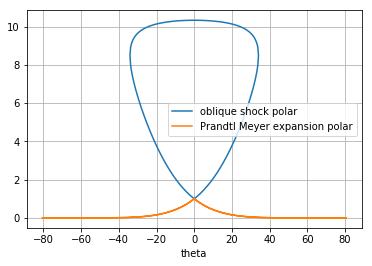

In [3]:
    theta1, p1 = polar(3)
    theta2, p2 = polarIsen(3)
    theta={1:theta1,
           2:theta2
          }
 
    p    = {1:p1,
            2:p2,
            }
    
    label = {1: 'oblique shock polar',
             2: 'Prandtl Meyer expansion polar'}
    plot(theta,p,label,name='polars')

Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.623753
         Iterations: 20
         Function evaluations: 40
ThetaMax: [35.73844174]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40


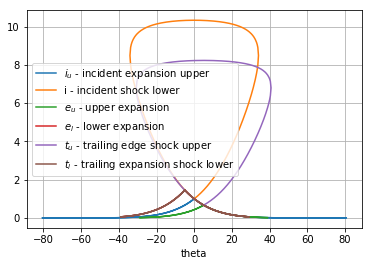

Pressure ration solutions:
5.000695076399477 degrees : 0.6675166849261567
5.000695076399477 degrees : 0.6675166849261567
---------------------------------------------------------
Trailing edge downward Deflection angle : 0.05234186841468338
M0 : 3
M1 upper : 3.2732421337309536
M2 upper : 3.27338735083189
M3 upper : 3.270373678359146
M1 lower : 2.7497087589696996
M2 lower : 2.7499716363384326
M3 lower : 2.752699420298809
---------------------------------------------------------


C:\Users\sagar\Jupyter Notebooks\Academics\Shockwave Dynamics\intersection.py:86: RuntimeWarning: invalid value encountered in greater_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)
C:\Users\sagar\Jupyter Notebooks\Academics\Shockwave Dynamics\intersection.py:86: RuntimeWarning: invalid value encountered in less_equal
  in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)


[3.2732421337309536,
 3.27338735083189,
 3.270373678359146,
 2.7497087589696996,
 2.7499716363384326,
 2.752699420298809]

In [5]:
diamonAirfoil(beta=0,alpha=5)

Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.672051
         Iterations: 20
         Function evaluations: 40
ThetaMax: [38.5057039]
Optimization terminated successfully.
         Current function value: -0.614748
         Iterations: 20
         Function evaluations: 40
ThetaMax: [35.22246471]


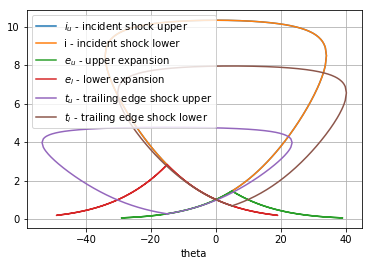

Pressure ration solutions:
15.462806683852655 degrees : 4.752483103816741
-10.278445446635063 degrees : 0.9914663432536026
---------------------------------------------------------
Trailing edge downward Deflection angle : -10.278445446635063
M0 : 3
M1 upper : 2.7497087589696996
M2 upper : 3.917968520413583
M3 upper : 3.205450420845086
M1 lower : 2.25490231226494
M2 lower : 3.1819292466451476
M3 lower : 2.6377953472520907
---------------------------------------------------------


[2.7497087589696996,
 3.917968520413583,
 3.205450420845086,
 2.25490231226494,
 3.1819292466451476,
 2.6377953472520907]

In [5]:
diamonAirfoil(beta=10,alpha=5)

Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.692609
         Iterations: 20
         Function evaluations: 40
ThetaMax: [39.68356874]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40


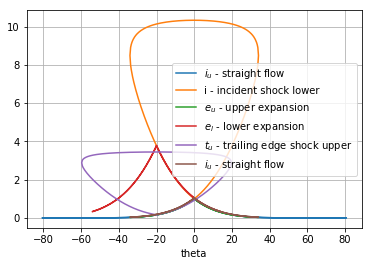

Pressure ration solutions:
0.6810962372229916 degrees : 0.17188761386121498
0.6810962372229916 degrees : 0.17188761386121498
---------------------------------------------------------
Trailing edge downward Deflection angle : 0.6810962372229916
M0 : 3
M1 upper : 3
M2 upper : 4.317831807117545
M3 upper : 4.260600699635001
M1 lower : 1.9941316655645596
M2 lower : 2.823003067168944
M3 lower : 2.823003067168944
---------------------------------------------------------


[3,
 4.317831807117545,
 4.260600699635001,
 1.9941316655645596,
 2.823003067168944,
 2.823003067168944]

In [6]:
diamonAirfoil(beta=10,alpha=10)

Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
ThetaMax: [34.07343977]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.710534
         Iterations: 20
         Function evaluations: 40
ThetaMax: [40.710608]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 20
         Function evaluations: 40


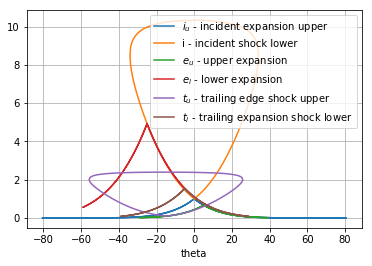

Pressure ration solutions:
6.49260100042013 degrees : 0.10786115100542966
6.49260100042013 degrees : 0.10786115100542966
---------------------------------------------------------
Trailing edge downward Deflection angle : 6.49260100042013
M0 : 3
M1 upper : 3.2732421337309536
M2 upper : 4.776543491778904
M3 upper : 4.168074345807385
M1 lower : 1.7172584978830432
M2 lower : 2.465877151015993
M3 lower : 2.7559612500442507
---------------------------------------------------------


[3.2732421337309536,
 4.776543491778904,
 4.168074345807385,
 1.7172584978830432,
 2.465877151015993,
 2.7559612500442507]

In [7]:
diamonAirfoil(beta=10,alpha=15)